# Genetic Algorithm NeuroEvolution
Evolving the weights of a fixed Neural Controller using Genetic Algorithm

In [2]:
import importlib
import environment 
import neural_controller
import utils
importlib.reload(environment)
importlib.reload(neural_controller)
importlib.reload(utils)

import numpy as np
import time

In [3]:
initial_setting = {
   'agents': np.array([[0, 5], [0, 10], [0, 15]], dtype=float),
   'blocks': np.array([[9, 16], [10, 12], [11, 6]], dtype=float),
   'colors': np.array([environment.RED, environment.GREEN, environment.RED], dtype=int)
}

env = environment.Environment(objective = [(environment.RED, environment.NORTH_EDGE)],
                   size = environment.SIMULATION_ARENA_SIZE, 
                   n_agents = 3, 
                   n_blocks = 3,
                   n_neighbors = 3,
                   sensor_range = environment.SIMULATION_SENSOR_RANGE,
                   sensor_angle = 360,
                   max_distance_covered_per_step = environment.SIMULATION_MAX_DISTANCE,
                   sensitivity = 0.2,
                   initial_setting = initial_setting)
env.reset(seed = 12)
env.print_env()

. . . . . . 0 . . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . O . . . . . . . . .
. . . . . . . . O . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .


In [5]:
input_dim = (env.n_types + 2) * env.n_neighbors + env.n_types - 2
output_dim = 2
hidden_units = [16]
layer_sizes = [input_dim] + hidden_units + [output_dim]

nn = neural_controller.NeuralController(layer_sizes, hidden_activation="sigmoid", output_activation="sigmoid")
nn.summary()

NeuralController with layer sizes:  [44, 16, 2]
Total weights: 754, not set


In [6]:
def select_parents(population, fitnesses, n_parents, tournament_size=5, p = 0.6):
    def tournament():
        # Choose k (the tournament size) individuals from the population at random
        participants = np.random.randint(len(population), size=tournament_size)
        random_number = np.random.rand()
        cumulative_probability = 0
        # Sort participants by fitness
        participants = sorted(participants, key=lambda x: fitnesses[x], reverse=True)
        for i, participant in enumerate(participants):
            # Choose the best/second/third... individual from the tournament 
            # with probability p/p*(1-p)/p*(1-p)^2...
            cumulative_probability += p * (1 - p) ** i 
            if cumulative_probability > random_number:
                return population[participant]
        
        return population[participants[-1]]

    # List to hold all selected parents
    parents = []
    # Generate n pairs of parents
    for _ in range(n_parents):
        parent1 = tournament()
        parent2 = tournament()
        # Ensure we get two different parents for diversity 
        while np.array_equal(parent1, parent2):
            parent2 = tournament()
        parents.append((parent1, parent2))
    
    return parents

def crossover(parents, crossover_rate=0.7):
    offspring = []
    for parent1, parent2 in parents:
        if np.random.rand() > crossover_rate:
            offspring.append(parent1)
        else:
            crossover_point = np.random.randint(len(parent1))
            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            offspring.append(child)
    return offspring

def mutate(offspring, mutation_rate=0.1):
    for child in offspring:
        if np.random.rand() < mutation_rate:
            random_gene = np.random.randint(0, len(child))
            child[random_gene] += np.clip(np.random.normal(), -3, 3)
    return offspring

In [7]:
def calculate_fitnesses(population : np.ndarray, 
                        network : neural_controller.NeuralController,
                        env : environment.Environment, 
                        n_steps=100,
                        verbose=False):
    
    fitnesses = np.zeros(len(population))
    flag_done = False
    best_steps = n_steps
    
    for genome_id, genome in enumerate(population):

        fitnesses[genome_id] = 0
        obs, _ = env.reset()
        
        # Set the weights of the network
        network.set_weights_from_vector(genome)

        for step in range(n_steps):
            
            nn_inputs = env.process_observation(obs)
            nn_outputs = np.array(network.predict(nn_inputs))
            actions = np.round(nn_outputs * np.array([env.max_distance_covered_per_step, env.sensor_angle]), 1)
                
            obs, reward, done, _, _ = env.step(actions)
            
            fitnesses[genome_id] += reward

            if verbose:
                print("\nStep", step)
                # print("Observation: ", obs)
                # print("NN inputs: ", nn_inputs)
                print("Action: ", actions)
                env.print_env()
                print("Reward: ", reward)
            
            if done:
                fitnesses[genome_id] += (n_steps - step) / 2
                flag_done = True
                if best_steps > step:
                    best_steps = step
                break
        
    if flag_done:
        print(f"Done in {best_steps} steps")
    
    return fitnesses

In [8]:
pop_size = 100
num_generations = 200
num_elite = int(0.05 * pop_size) # 5% of the population will be copied to the next generation (elitism)
num_removed = int(0.1 * pop_size) # 10% of the population will be removed and randomly replaced
tournament_size = int(0.03 * pop_size)
offspring_size = pop_size - num_elite - num_removed

population = np.random.uniform(-1, 1, (pop_size, nn.total_weights))
population.shape, num_elite, num_removed, tournament_size, offspring_size

((100, 754), 5, 10, 3, 85)

In [9]:
stats = []

patience = 0
for generation in range(num_generations):
    print(f"Generation {generation}")
    print(len(np.unique(population, axis=0)))
    start_gen = time.time()
    
    fitnesses = calculate_fitnesses(population, nn, env, n_steps=100)
    
    elite = population[np.argsort(fitnesses)][-num_elite:]

    replacements = np.random.normal(0, 1, (num_removed, nn.total_weights))
    
    parents = select_parents(population, fitnesses, offspring_size, tournament_size)
    
    offspring = crossover(parents)

    offspring = mutate(offspring)
    
    population = np.concatenate((elite, offspring, replacements), axis=0)

    end_gen = time.time()

    avg_fitness = np.mean(fitnesses)
    best_fitness = np.max(fitnesses)
    median_fitness = np.median(fitnesses)
    std_fitness = np.std(fitnesses)  
    stats.append((best_fitness, avg_fitness, median_fitness, std_fitness)) 
    print(f"Time taken: {round(end_gen- start_gen, 2)}")
    print(f"Best = {round(best_fitness, 2)}, Average = {round(avg_fitness, 2)}, Median = {round(median_fitness, 2)}, Std = {round(std_fitness, 2)}\n")

    # # Early stopping
    # if generation > 5:
    #     if best_fitness - stats[-2][0] < 0.1:
    #         patience += 1
    #         if patience > 20:
    #             print(f"Early stopping - no improvement in fitness ({best_fitness}).")
    #             break
    #     else:
    #         patience = 0
last_fitnesses = calculate_fitnesses(population, nn, env, n_steps=100)
best_genome = population[np.argmax(fitnesses)]
worst_genome = population[np.argmin(fitnesses)]

Generation 0
100
Time taken: 5.64
Best = 0.0, Average = -0.02, Median = 0.0, Std = 0.25

Generation 1
91
Time taken: 5.85
Best = 0.0, Average = -0.02, Median = 0.0, Std = 0.18

Generation 2
91
Time taken: 5.86
Best = 0.0, Average = -0.05, Median = 0.0, Std = 0.34

Generation 3
92
Time taken: 8.08
Best = 0.0, Average = -0.12, Median = 0.0, Std = 0.66

Generation 4
91
Time taken: 6.82
Best = 0.0, Average = -0.08, Median = 0.0, Std = 0.6

Generation 5
89
Time taken: 6.9
Best = 0.0, Average = -0.6, Median = 0.0, Std = 4.71

Generation 6
91
Time taken: 7.18
Best = 0.0, Average = -1.16, Median = 0.0, Std = 7.68

Generation 7
95
Time taken: 7.28
Best = 0.0, Average = -2.23, Median = 0.0, Std = 10.01

Generation 8
87
Time taken: 7.63
Best = 1.19, Average = -1.37, Median = 0.0, Std = 9.45

Generation 9
86
Time taken: 7.03
Best = 1.19, Average = -3.39, Median = 0.0, Std = 14.15

Generation 10
88
Time taken: 7.14
Best = 1.19, Average = -0.98, Median = 0.0, Std = 5.06

Generation 11
88
Time taken:

KeyboardInterrupt: 

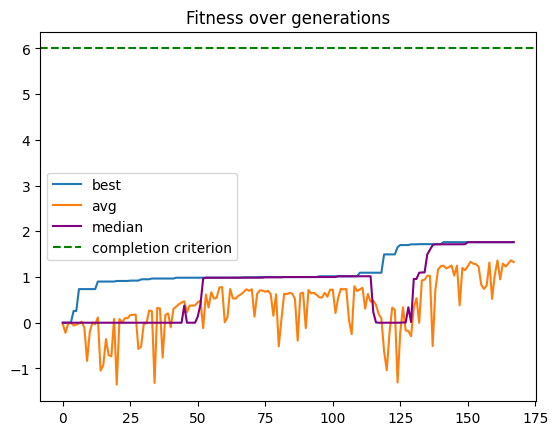

In [32]:
# Plot stats
bests, avgs, medians, stds = zip(*stats)

utils.plot_data(bests, avgs = avgs, medians = medians, 
                completion_fitness=env.n_task * (environment.REWARD_PICK + environment.REWARD_DROP))

In [34]:
calculate_fitnesses([best_genome], nn, env, n_steps=100, verbose=True)


Step 0
Action:  [[0.1 2.4]
 [0.1 2.4]
 [0.1 2.4]]
. . . . . . 0 . . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . O . . . . . . . . .
. . . . . . . . O . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .

array([1.76241074])